In [3]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
import tensorflow.compat.v1 as tf
import tensorflow as tf2

from DlModels import DlModels
from TrainDL import TrainDL
from DataLoader import DataLoader

In [2]:
# tf.test.is_gpu_available()

In [4]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


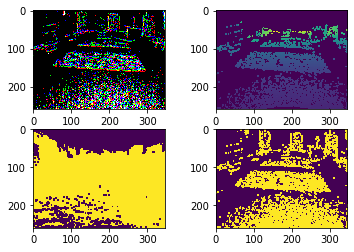

In [5]:
#test batching
data_loader = DataLoader('indoor_flying_augmented.hdf5')

event_images, depth_images, mask_1, mask_2 = data_loader.load_all()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(np.array(event_images[10][:,:,0:3]))
ax.autoscale(True)
ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
ax2.imshow(np.array(depth_images[10]))
ax2.autoscale(True)
ax3 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
ax3.imshow(np.array(mask_1[10]))
ax3.autoscale(True)
ax4 = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax4.imshow(np.array(mask_2[10]))
ax4.autoscale(True)
plt.show()


In [7]:
epochs = 20
batch_size = 1
base_learning_rate = 0.001
learning_decay_rate = 30
learning_decay_factor = 0.5
data_loader = DataLoader('indoor_flying_augmented.hdf5')

tf.compat.v1.disable_eager_execution()
input_image = tf.placeholder(tf.float32, [None, 9, None, None, 1], name='input_image')
depth_image = tf.placeholder(tf.float32, [None, None, None, 1], name='depth_image')
mask_image_1 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_1')
mask_image_2 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_2')
learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

sess = tf.Session()

# Build NN using load_vgg, layers, and optimize function
nn_last_layer = DlModels.Conv2dx2LSTMDecoder(input_image, DlModels.Conv2Dx1)

train_op, loss = TrainDL.NormalizedHuberOptimize(nn_last_layer, depth_image, mask_image_1, mask_image_2, learning_rate)

# Train NN using the train_nn function
TrainDL.train_nn(sess, epochs, batch_size, data_loader, train_op, loss, input_image, depth_image, mask_image_1, mask_image_2, learning_rate, base_learning_rate, learning_decay_rate, learning_decay_factor)
        
# save trained model
saver = tf.train.Saver()
saver.save(sess, './model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training...

EPOCH 1 ...
Loss: =
0.6015567390620709

EPOCH 2 ...
Loss: =
0.5271143235266209

EPOCH 3 ...
Loss: =
0.5233314995467663

EPOCH 4 ...
Loss: =
0.5054091261327267

EPOCH 5 ...
Loss: =
0.48048503190279007

EPOCH 6 ...
Loss: =
0.46926545768976213

EPOCH 7 ...
Loss: =
0.43545050725340845

EPOCH 8 ...
Loss: =
0.42474422231316566

EPOCH 9 ...
Loss: =
0.4335690228641033

EPOCH 10 ...
Loss: =
0.4153441771864891

EPOCH 11 ...
Loss: =
0.4105391272902489

EPOCH 12 ...
Loss: =
0.3897996087372303

EPOCH 13 ...
Loss: =
0.38577377393841744

EPOCH 14 ...
Loss: =
0.37431621305644514

EPOCH 15 ...
Loss: =
0.3741226701438427

EPOCH 16 ...
Loss: =
0.37006191074848177

EPOCH 17 ...
Loss: =
0.3455886541306972

EPOCH 18 ...
Loss: =
0.33808277279138566

EPOCH 19 ...
Loss: =
0.34351905960589646

EPOCH 20 ...
Loss: =
0.3324012127518654



'./model'

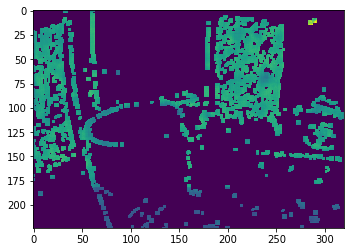

In [11]:
sample_image = [event_images[70][0:224, 0:320, :]]
sample_image = np.swapaxes(sample_image, 0, 3)
sample_image = [np.flip(sample_image, axis=0)]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image})

#plt.imshow(est_depth[0].reshape(target_height, target_width))
plt.imshow(np.multiply(mask_2[70][0:224, 0:320],  est_depth[0].reshape(224, 320)))

In [7]:
plt.imshow(sample_image[:,:,0])

NameError: name 'sample_image' is not defined

In [8]:
plt.imshow(depth_images[70])

NameError: name 'depth_images' is not defined

In [9]:
#Convert to pointcloud
import open3d
from open3d import geometry
from open3d import visualization
import cv2
g = open3d.camera.PinholeCameraIntrinsic()
g.set_intrinsics(346, 260, 226.0181418548734, 225.7869434267677, 174.5433576736815, 124.21627572590607)

sample_image = event_images[270][0:224, 0:320, :]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image.reshape(1, 224, 320, 9)})

padded_array = np.zeros((260, 346))
padded_array[:224, :320] = np.multiply(mask_2[270][0:224, 0:320],  est_depth[0].reshape(224, 320))
#padded_array[:224, :320] = np.multiply(mask_2[270][0:224, 0:320],  depth_images[270][:224, :320])
image = geometry.Image(np.float32(padded_array))

pointcloud = geometry.PointCloud.create_from_depth_image(image, g, depth_scale=1.0)
visualization.draw_geometries([pointcloud])
open3d.io.write_point_cloud("copy_of_fragment.pcd", pointcloud)

NameError: name 'event_images' is not defined

In [10]:
import numpy as np

g = np.array([[[1,2, 3], [1,2, 3]], [[3,4, 5], [3,4,5]]])

print(g)

np.swapaxes([g], 0,2)
print(g)
print(np.shape(np.swapaxes([g], 0,3)))

[[[1 2 3]
  [1 2 3]]

 [[3 4 5]
  [3 4 5]]]
[[[1 2 3]
  [1 2 3]]

 [[3 4 5]
  [3 4 5]]]
(3, 2, 2, 1)
